In [1]:
!pip install -U bitsandbytes transformers accelerate lime captum lxt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 73.1 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=94c286e5e9ffeedfe574557fe75f90ab28a7d55ac1b9c93f364b6e4f435a2cd7
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Make sure to upload utils.py
upload_utils = files.upload()

Saving utils.py to utils.py


In [1]:
import os
import sys

path = os.getcwd()
while True:
    if 'utils.py' in os.listdir(path):
        if path not in sys.path:
            sys.path.append(path)
        break
    new_path = os.path.dirname(path)
    if new_path == path:
        print("utils.py not found in any parent folder.")
        break
    path = new_path

import utils
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

c:\Users\User\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
utils.hf_login("HF_TOKEN")

In [5]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [6]:
model_id = 'mistralai/Mistral-7B-Instruct-v0.3'

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quantization_config,
    attn_implementation="eager"
    )

# Add padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

# Change the model to evaluation mode
model.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [7]:
files.upload()
scitail_test = pd.read_csv('scitail_test.csv')

Saving scitail_test.csv to scitail_test.csv


In [ ]:
scitail_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   premise                     2126 non-null   object
 1   hypothesis                  2126 non-null   object
 2   label                       2126 non-null   object
 3   hypothesis_graph_structure  2126 non-null   object
dtypes: object(4)
memory usage: 66.6+ KB


In [ ]:
scitail_test.head()

,premise,hypothesis,label,hypothesis_graph_structure
0,Based on the list provided of the uses of subs...,"If a substance has a ph value greater than 7,t...",neutral,a substance<>has<>a ph value greater than 7
1,If one or two base pairs are change...,Invertebrates (and higher animals) can also be...,neutral,Invertebrates (and higher animals<>can be plac...
2,"At high temperatures, the solid dye converts i...",Gases and liquids become solids at low tempera...,neutral,Gases and liquids<>become<>solids
3,Chapter 11 Gas and Kinetic Theory .,The behavior of ideal gases is explained by ki...,neutral,The behavior of ideal gases<>is explained<>by ...
4,Both the continental crust and the oceanic cru...,Gabbro is a dark dense rock that can be found ...,neutral,Gabbro<>is<>a dark dense rock that can be foun...


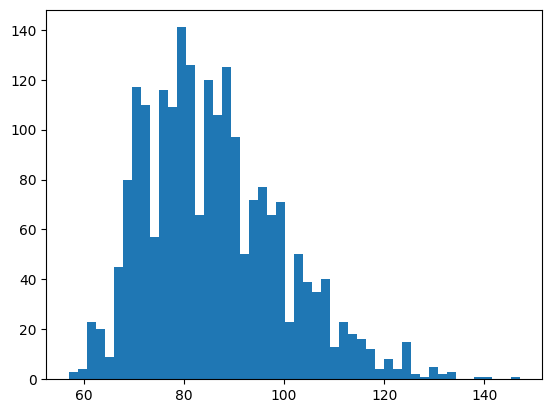

Max prompt length: 147
Max label length: 3


In [ ]:
# Find the max_length for tokenization to avoid wasting computing.
utils.find_max_length(scitail_test, tokenizer=tokenizer, dataset_type='scitail')

In [8]:
# Define dataset and create a dataloader.
dataset_test = utils.MyDataset(dataframe=scitail_test,
                               tokenizer=tokenizer,
                               dataset_type='scitail',
                               prompt_max_length=117,
                               label_max_length=3)

batch_size = 16 # Change batch size according to GPU
dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
# Test
predictions, gold_labels, batch_probs = utils.test_run(model=model,
                                          dataloader=dataloader,
                                          tokenizer=tokenizer,
                                          dataset_type='scitail')


In [ ]:
for i, pair in enumerate(zip(predictions, gold_labels)):
    print(pair, batch_probs[i])

('neutral', 'neutral') tensor([0.0054, 0.6499])
('neutral', 'neutral') tensor([2.0065e-04, 6.3184e-01])
('neutral', 'neutral') tensor([0.0006, 0.5068])
('entails', 'neutral') tensor([0.4612, 0.0419])
('neutral', 'neutral') tensor([0.0029, 0.6899])
('neutral', 'neutral') tensor([0.0058, 0.6411])
('entails', 'entails') tensor([0.4497, 0.0114])
('entails', 'entails') tensor([0.3402, 0.0681])
('entails', 'entails') tensor([0.4275, 0.0626])
('neutral', 'neutral') tensor([0.0015, 0.6753])
('neutral', 'neutral') tensor([3.5143e-04, 6.0156e-01])
('neutral', 'neutral') tensor([0.1124, 0.5986])
('entails', 'entails') tensor([0.4292, 0.0250])
('entails', 'neutral') tensor([0.1868, 0.1216])
('entails', 'neutral') tensor([3.1694e-05, 9.5367e-06])
('neutral', 'neutral') tensor([0.0286, 0.6265])


In [3]:
# Create checkpoint
checkpoint_path = utils.create_checkpoint_path(model_id='mistralai/Mistral-7B-Instruct-v0.3', name='scitail')

Saving to: c:\Users\User\iCloudDrive\Desktop\DAMA_EAP\NLI_Study\Notebooks\Scitail_Notebooks\Scitail-Mistral-7B-Instruct-v0.3-zero-shot\checkpoint_scitail_Mistral_7B_Instruct_v0.3.pt


In [ ]:
from tqdm import tqdm

# Load checkpoint if it exists
predicted_labels, gold_labels, start_batch = utils.load_checkpoint(checkpoint_path=checkpoint_path)
labels = utils.get_labels('scitail')

# Loop over the batches
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader, desc="Evaluating", unit="batch")):

        # Continue from last checkpoint
        if i < start_batch:
            continue

        input_ids_batch = batch["input_ids"].to(model.device) # Move to GPU
        attention_mask_batch = batch["attention_mask"].to(model.device) # Move to GPU
        gold_labels_batch = batch["labels"] # Keep to CPU

        batch_probs = utils.get_model_probs(input_ids=input_ids_batch,
                                      attention_mask=attention_mask_batch,
                                      dataset_type='scitail',
                                      model=model,
                                      tokenizer=tokenizer)

        batch_pred_indices = torch.argmax(batch_probs, dim=1)
        batch_pred_labels = [labels[i] for i in batch_pred_indices]

        predicted_labels.extend(batch_pred_labels)
        gold_labels.extend(gold_labels_batch)

        # Save checkpoint
        if i % 50 == 0 or i == len(dataloader) - 1:
            torch.save({"predicted_labels": predicted_labels,
                        "gold_labels": gold_labels,
                        "batch_no": i+1}, checkpoint_path)

            print(f"Checkpoint saved: {i+1}, {checkpoint_path}")

Checkpoint found.
Accuracy: 0.8236.
 F1 Score: 0.8190.
 Matthew's Correlation Coefficient: 0.6421.
 Cohen's Kappa Score: 0.6389.


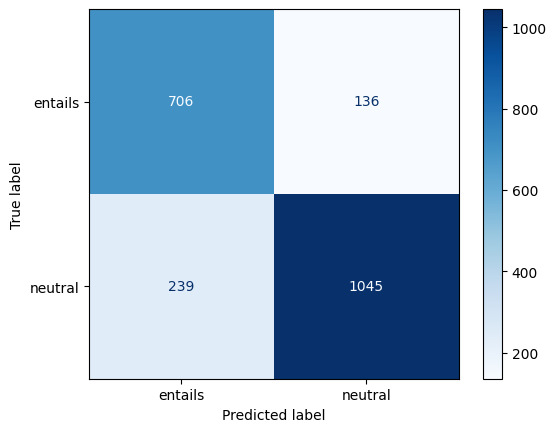

In [5]:
# Calculate metrics
predicted_labels, gold_labels, _ = utils.load_checkpoint(checkpoint_path)
utils.evaluate_metrics(predicted_labels=predicted_labels, gold_labels=gold_labels, dataset_type='scitail')

In [16]:
from functools import partial

class_names = utils.get_labels('scitail')
text_instance = dataset_test[0]['prompt']

# Wrapper function for Lime and SHAP
predict_fn_partial = partial(utils.predict_fn, model=model, tokenizer=tokenizer, dataset_type='scitail')

In [17]:
# Application of LIME
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
exp1 = explainer.explain_instance(text_instance,
                                 predict_fn_partial,
                                 num_features=6,
                                 num_samples=500)

In [18]:
exp1.show_in_notebook()

In [19]:
# Application of SHAP
import shap

masker = shap.maskers.Text(tokenizer, mask_token=tokenizer.pad_token)
shap_explainer = shap.Explainer(predict_fn_partial, masker, output_names=class_names)
shap_values = shap_explainer([text_instance])

# Now plot
shap.plots.text(shap_values[0])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [24:24, 1464.27s/it]             


In [ ]:
# Prepare model for IG/LRP

# Deactivate gradients on params
for param in model.parameters():
    param.requires_grad = False

In [ ]:
from importlib import reload
reload(utils)

# Application of IG
from functools import partial
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

# A list of records to be visualized
data_records = []
example_id = 0
input_ids = dataset_test[example_id]['input_ids'].unsqueeze(0)
attention_mask = dataset_test[example_id]['attention_mask'].unsqueeze(0)
predict_fn_ig = partial(utils.predict_fn_pretokenized, model=model, tokenizer=tokenizer, dataset_type='scitail')

# Get index of the predicted label and use as target label to be explained
pred = torch.tensor(predict_fn_ig(input_ids, attention_mask, model=model, tokenizer=tokenizer, dataset_type='scitail'))
pred_label_id = torch.argmax(pred, dim=-1).item() # id is based on class_names
pred_prob = pred.squeeze(0)[pred_label_id].item()

# Wrap function for IG, returns logits
forward_pass_fn_partial = partial(utils.forward_pass_fn, 
                                  model=model, 
                                  pred_label_id=pred_label_id,
                                  tokenizer=tokenizer,
                                  class_names=class_names,
                                  ) 

ig = IntegratedGradients(forward_pass_fn_partial)

# Add to data records
utils.interpret_example(model=model,
                        tokenizer=tokenizer,
                        example_id=example_id,
                        ig=ig,
                        data_records=data_records,
                        class_names=class_names,
                        pred_label_id=pred_label_id,
                        pred_prob=pred_prob,
                        dataset=dataset_test)

AssertionError: Target not provided when necessary, cannot take gradient with respect to multiple outputs.

In [1]:
# Visualise the examples
viz.visualize_text(data_records)

KeyboardInterrupt: 

In [ ]:
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-latex-extra

In [ ]:
# Application of LRP
from lxt.utils import pdf_heatmap, clean_tokens

# def interpret_example_LRP(model, tokenizer, example_id, ig, data_records, class_names, pred_label_id, pred_prob, dataset):
input_ids = dataset_test[0]['input_ids'].unsqueeze(0).to(model.device)

# Get input embeddings
input_embeds = model.get_input_embeddings()(input_ids).detach().requires_grad_() # Make sure to activate grad again
output_logits = model(inputs_embeds=input_embeds, use_cache=False).logits 

# Take max logit at last pos
max_logits, max_indices = torch.max(output_logits[0, -1, :], dim=-1)

# Backward pass
max_logits.backward()

# Obtain relevance
relevance = (input_embeds.grad * input_embeds).float().sum(-1).detach().cpu()

# Normalise relevance between [-1,1]
relevance = relevance / relevance.abs().max()

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens = clean_tokens(tokens)

# Save heatmap as PDF
pdf_heatmap(tokens, relevance[0], path='mistral_heatmap2.pdf', backend='xelatex')